In [1]:
import pandas as pd
import numpy as np
from Bio import SeqIO
from matplotlib import pyplot as plt

In [2]:
complete4sensors = pd.read_csv('complete_4sensors/ecrassus_complete_v1.gff3', sep='\t', comment='#', 
            names=['seq_id','source','type','start','end', 'score', 'strand','phase', 'attributes'] )
complete12sensors = pd.read_csv('complete_12sensors/ecrassus_complete_v1.gff3', sep='\t', comment='#', 
            names=['seq_id','source','type','start','end', 'score', 'strand','phase', 'attributes'] )

genome_fasta = SeqIO.to_dict(SeqIO.parse('ecrassus_DP1_asm_filtered.fasta', 'fasta'))

In [3]:
# function that creates a gff like dataframe with frameshifts given a dataframe containing CDS
def create_FS_df(in_df):
    in_df_CDS = in_df[in_df['type']=='CDS']
   
    fs1_list = []
    fs2_list = []
    for i in range(len(in_df_CDS)-1):
        if not in_df_CDS.iloc[i]['seq_id'] == in_df_CDS.iloc[i+1]['seq_id']:
            continue
        if in_df_CDS.iloc[i+1]['start'] - in_df_CDS.iloc[i]['end'] == 2: # +1 Frameshift
            line = in_df_CDS.iloc[i+1].copy()
            line['start'] = line['start']-1
            line['end'] = line['start']
            line['type'] = '+1_fs'
            line['attributes'] = 'Name=+1_Frameshift'
            fs1_list.append(line)
            
        if in_df_CDS.iloc[i+1]['start'] - in_df_CDS.iloc[i]['end'] == 3: # +2 Frameshift
            line = in_df_CDS.iloc[i+1].copy()
            line['start'] = line['start']-2
            line['end'] = line['start']+1
            line['type'] = '+2_fs'
            line['attributes'] = 'Name=+2_Frameshift'
            fs2_list.append(line)
            
    
    return (pd.DataFrame(fs1_list), pd.DataFrame(fs2_list))

In [4]:
# extract the frameshift regions given in a dataframe from the sequences given in fasta
def fs_regions(df, fasta, regionsize):
    regions = []
    for i in range(len(df)):
        fs = df.iloc[i]
        r = regionsize//2
        if fs['strand'] == '+':
            seq = fasta[fs['seq_id']].seq
            start = fs['start']-r-1
            end = fs['start']+r
            regions.append(str(seq)[start:end])
        else:
            seq = fasta[fs['seq_id']].seq.reverse_complement()
            start = len(seq) - fs['end'] - r 
            end = len(seq) - fs['end'] + r +1
            regions.append(str(seq)[start:end])
    return regions

In [5]:
# create frameshift dataframes
complete4sensors_1fs, complete4sensors_2fs = create_FS_df(complete4sensors)
complete12sensors_1fs, complete12sensors_2fs = create_FS_df(complete12sensors)

In [6]:
# create files with frameshift regions for seq logos
file=open('12sensors_1fs_regions_g.txt','w')
file.writelines([i+'\n' for i in fs_regions(complete12sensors_1fs, genome_fasta, 15) if i[9]=='G'])
file.close()
file=open('12sensors_2fs_regions_g.txt','w')
file.writelines([i+'\n' for i in fs_regions(complete12sensors_2fs, genome_fasta, 15) if i[9]=='G'])
file.close()
file=open('4sensors_1fs_regions_g.txt','w')
file.writelines([i+'\n' for i in fs_regions(complete4sensors_1fs, genome_fasta, 15) if i[9]=='G'])
file.close()
file=open('4sensors_2fs_regions_g.txt','w')
file.writelines([i+'\n' for i in fs_regions(complete4sensors_2fs, genome_fasta, 15) if i[9]=='G'])
file.close()
file=open('12sensors_1fs_regions_a.txt','w')
file.writelines([i+'\n' for i in fs_regions(complete12sensors_1fs, genome_fasta, 15) if i[9]=='A'])
file.close()
file=open('12sensors_2fs_regions_a.txt','w')
file.writelines([i+'\n' for i in fs_regions(complete12sensors_2fs, genome_fasta, 15) if i[9]=='A'])
file.close()
file=open('4sensors_1fs_regions_a.txt','w')
file.writelines([i+'\n' for i in fs_regions(complete4sensors_1fs, genome_fasta, 15) if i[9]=='A'])
file.close()
file=open('4sensors_2fs_regions_a.txt','w')
file.writelines([i+'\n' for i in fs_regions(complete4sensors_2fs, genome_fasta, 15) if i[9]=='A'])
file.close()

In [7]:
# count the codons preceding the frameshift and the codons in the CDS
d_4_1 = {}
d_4_2 = {}
d_12_1 = {}
d_12_2 = {}
codon_dist = {}
alphabet = ['A','C', 'G', 'T']
for n1 in alphabet:
    for n2 in alphabet:
        for n3 in alphabet:
            d_4_1[n1+n2+n3] = 0
            d_4_2[n1+n2+n3] = 0
            d_12_1[n1+n2+n3] = 0
            d_12_2[n1+n2+n3] = 0
            codon_dist[n1+n2+n3] = 0
for df, d in zip([complete4sensors_1fs, complete4sensors_2fs, complete12sensors_1fs, complete12sensors_2fs],[d_4_1,d_4_2,d_12_1,d_12_2]):
    for i in [i[:3] for i in fs_regions(df, genome_fasta, 6)]:
        d[i] +=1
        
codon_num = 0
for seq in SeqIO.parse('complete_12sensors/ecrassus_complete_v1_cds.fna', 'fasta'):
    for i in range(0,len(seq),3):
        codon_dist[seq.seq[i:i+3]]+=1
        codon_num +=1
        
counts_df = pd.DataFrame(index=d_4_1.keys())
counts_df['d_4_1'] = d_4_1.values()
counts_df['d_4_2'] = d_4_2.values()
counts_df['d_12_1'] = d_12_1.values()
counts_df['d_12_2'] = d_12_2.values()

counts_df['codon_dist'] = [i/codon_num for i in codon_dist.values()]

counts_df['d_4_1_ratio'] = np.log2(counts_df['d_4_1']/(counts_df['codon_dist']*counts_df['d_4_1'].sum()))

counts_df['d_4_2_ratio'] = np.log2(counts_df['d_4_2']/(counts_df['codon_dist']*counts_df['d_4_2'].sum()))

counts_df['d_12_1_ratio'] = np.log2(counts_df['d_12_1']/(counts_df['codon_dist']*counts_df['d_12_1'].sum()))

counts_df['d_12_2_ratio'] = np.log2(counts_df['d_12_2']/(counts_df['codon_dist']*counts_df['d_12_2'].sum()))

counts_df.head()

/home/kilian/miniconda3/envs/main/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,d_4_1,d_4_2,d_12_1,d_12_2,codon_dist,d_4_1_ratio,d_4_2_ratio,d_12_1_ratio,d_12_2_ratio
AAA,13640,1622,14277,1152,0.053199,3.090163,0.714173,3.882855,1.985066
AAC,364,345,106,74,0.024399,-1.013025,-0.394358,-2.066056,-0.850832
AAG,643,458,319,140,0.048363,-1.179234,-0.972697,-1.463654,-0.918092
AAT,835,643,340,115,0.037449,-0.433285,-0.114234,-1.002684,-0.832893
ACA,192,221,31,82,0.015708,-1.300562,-0.401614,-3.204485,-0.067438


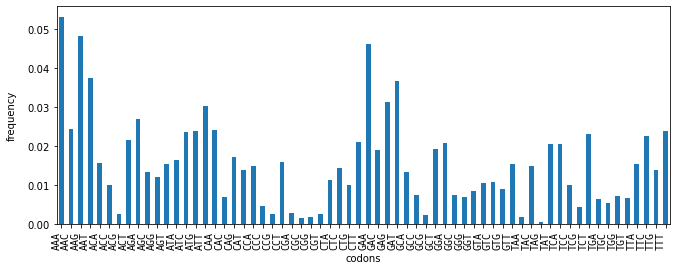

In [8]:
# CDS codon distribution
ax = counts_df['codon_dist'].plot.bar(figsize=(11,4))
                                
ax.set_xlabel('codons')
ax.set_ylabel('frequency',rotation=90,labelpad=10)
mono_font={'fontname':'monospace'}
ax.set_xticklabels(counts_df.index,rotation=90, ha='right', **mono_font)
pass

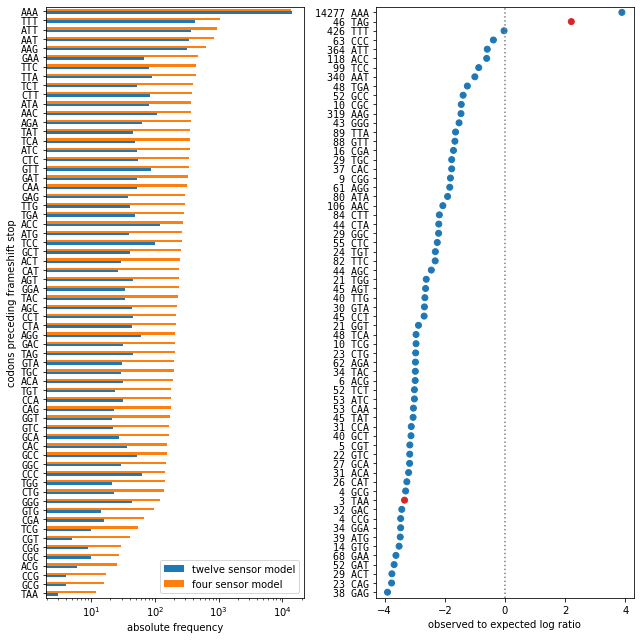

In [9]:
# distribution of codons preceding the frameshifts
fig,axs = plt.subplots(1,2,figsize=(9,9))

temp = counts_df[['d_12_1','d_4_1']].sort_values(by='d_4_1', ascending=True).rename(columns={'d_4_1':'four sensor model','d_12_1':'twelve sensor model'})
axs[0] = temp.plot.barh(logx=True, ax=axs[0])
axs[0].set_xlabel('absolute frequency')
axs[0].set_ylabel('codons preceding frameshift stop')
axs[0].set_yticklabels(temp.index,**mono_font)

temp=counts_df.sort_values(by='d_12_1_ratio',ascending=True)
colors = ['tab:red' if ((i=='TAG') or (i=='TAA')) else 'tab:blue' for i in temp.index]
axs[1]=plt.scatter(temp['d_12_1_ratio'],temp.index,c=colors)
plt.axvline(0,color='grey', linestyle=':')

plt.xlabel('observed to expected log ratio')

ticks = [str(temp['d_12_1'].loc[i])+' '+i for i in temp.index]
locs,_ = plt.yticks()
plt.yticks(locs, ticks, **mono_font)
plt.margins(y=.01)

fig.tight_layout()


In [10]:
mrna_df = complete12sensors[complete12sensors['type']=='mRNA'].drop_duplicates(subset='seq_id', keep=False).set_index('seq_id')
mrna_fs_df = mrna_df.merge(complete12sensors_1fs, on='seq_id', suffixes=['_mrna','_fs'])
mrna_fs_df.head()

,seq_id,source_mrna,type_mrna,start_mrna,end_mrna,score_mrna,strand_mrna,phase_mrna,attributes_mrna,source_fs,type_fs,start_fs,end_fs,score_fs,strand_fs,phase_fs,attributes_fs
0,NODE_7_length_16369_cov_5.665_ID_3072668,EuGene,mRNA,92,16283,.,-,.,ID=mRNA:NODE_7_length_16369_cov_5.665_ID_30726...,EuGene,+1_fs,7552,7552,.,-,2,Name=+1_Frameshift
1,NODE_7_length_16369_cov_5.665_ID_3072668,EuGene,mRNA,92,16283,.,-,.,ID=mRNA:NODE_7_length_16369_cov_5.665_ID_30726...,EuGene,+1_fs,9295,9295,.,-,0,Name=+1_Frameshift
2,NODE_11_length_15204_cov_51.6764_ID_3072676,EuGene,mRNA,54,14907,.,-,.,ID=mRNA:NODE_11_length_15204_cov_51.6764_ID_30...,EuGene,+1_fs,14181,14181,.,-,0,Name=+1_Frameshift
3,NODE_11_length_15204_cov_51.6764_ID_3072676,EuGene,mRNA,54,14907,.,-,.,ID=mRNA:NODE_11_length_15204_cov_51.6764_ID_30...,EuGene,+1_fs,14467,14467,.,-,0,Name=+1_Frameshift
4,NODE_13_length_14706_cov_18.7689_ID_3072680,EuGene,mRNA,61,14467,.,-,.,ID=mRNA:NODE_13_length_14706_cov_18.7689_ID_30...,EuGene,+1_fs,5790,5790,.,-,2,Name=+1_Frameshift


Text(0.5, 0, '(negative) distance of frameshift \nto end of transcript scaled to the transcript length')

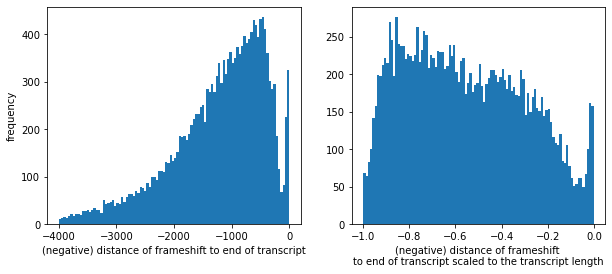

In [11]:
# plot the distribution of distances of the frameshifts to the end of the transcripts
# (absolute and relative to transcript length)
fig,axs = plt.subplots(1,2,figsize=(10,4))
to_end = mrna_fs_df[mrna_fs_df['strand_mrna']=='-'].apply(lambda x: x['start_mrna']-x['end_fs'], axis=1)
to_end2= mrna_fs_df[mrna_fs_df['strand_mrna']=='+'].apply(lambda x: -x['end_mrna']+x['end_fs'], axis=1)

to_start = mrna_fs_df[mrna_fs_df['strand_mrna']=='+'].apply(lambda x: -x['start_mrna']+x['end_fs'], axis=1)
to_start2 = mrna_fs_df[mrna_fs_df['strand_mrna']=='-'].apply(lambda x: x['end_mrna']-x['end_fs'], axis=1)

axs[0].hist(to_end.append(to_end2), bins=100, range=(-4000,0))
axs[0].set_xlabel('(negative) distance of frameshift to end of transcript')
axs[0].set_ylabel('frequency')


to_end = mrna_fs_df[mrna_fs_df['strand_mrna']=='-'].apply(lambda x: ( x['start_mrna']-x['end_fs'])/(x['end_mrna']-x['start_mrna']), axis=1)
to_end2= mrna_fs_df[mrna_fs_df['strand_mrna']=='+'].apply(lambda x: (-x['end_mrna']+x['end_fs'])/(x['end_mrna']-x['start_mrna']), axis=1)

axs[1].hist(to_end.append(to_end2), bins=100)
axs[1].set_xlabel('(negative) distance of frameshift \nto end of transcript scaled to the transcript length')


Text(0.5, 0, 'number of frameshifts predicted in a nanochromosome')

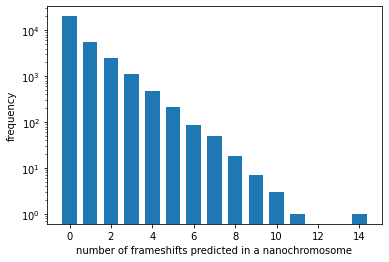

In [12]:
# number of frameshifts per chromosome
chromosomes_df = pd.DataFrame([[key,len(genome_fasta[key])] for key in genome_fasta.keys()],columns=('seq_id', 'length')).set_index('seq_id')
chromosomes_df['#fs'] = complete12sensors_1fs.groupby('seq_id').size()
chromosomes_df = chromosomes_df.fillna(0)
plt.hist(chromosomes_df['#fs'], range=(-.5,14.5), rwidth=.7, bins=15)
plt.yscale('log')
plt.ylabel('frequency')
plt.xlabel('number of frameshifts predicted in a nanochromosome')

In [13]:
stringtie_df = pd.read_csv('transcripts.gtf', sep='\t', comment='#',
            names=['seq_id','source','type','start','end', 'score', 'strand','phase', 'attributes'] )

tpm = stringtie_df.apply(lambda x: float(x['attributes'].split('\"')[-2]),axis=1)
stringtie_df.insert(5,'TPM',tpm)

transcripts_df = stringtie_df.drop_duplicates('seq_id').merge(chromosomes_df, on='seq_id')

transcripts_df.head()

,seq_id,source,type,start,end,TPM,score,strand,phase,attributes,length,#fs
0,NODE_1_length_50899_cov_36.2793_ID_3072656,StringTie,transcript,18948,36583,0.135644,1000,-,.,"gene_id ""STRG.1""; transcript_id ""STRG.1.1""; co...",50899,0.0
1,NODE_4_length_20956_cov_11.1866_ID_3072662,StringTie,transcript,29,20912,0.618637,1000,+,.,"gene_id ""STRG.4""; transcript_id ""STRG.4.1""; co...",20956,0.0
2,NODE_5_length_17939_cov_20.7119_ID_3072664,StringTie,transcript,91,17884,0.676872,1000,+,.,"gene_id ""STRG.6""; transcript_id ""STRG.6.1""; co...",17939,0.0
3,NODE_7_length_16369_cov_5.665_ID_3072668,StringTie,transcript,11517,12284,0.086409,1000,-,.,"gene_id ""STRG.7""; transcript_id ""STRG.7.1""; co...",16369,2.0
4,NODE_9_length_15547_cov_9.84695_ID_3072672,StringTie,transcript,2364,3118,0.063173,1000,-,.,"gene_id ""STRG.12""; transcript_id ""STRG.12.1""; ...",15547,0.0


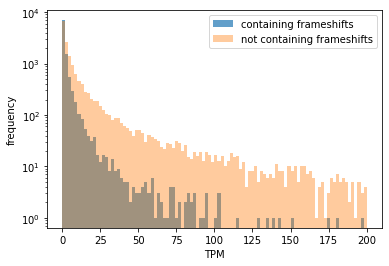

In [14]:
# transcript abundance distributions of frameshift containing and not frameshift containing transcripts
plt.hist(transcripts_df[transcripts_df['#fs']>0]['TPM'], bins=100, alpha=.7, range=(0,200))
plt.hist(transcripts_df[transcripts_df['#fs']==0]['TPM'], bins=100, alpha=.4, range=(0,200))
plt.legend(['containing frameshifts','not containing frameshifts'])
plt.yscale('log')
plt.xlabel('TPM')
plt.ylabel('frequency')
pass

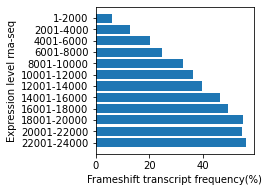

In [15]:
# fraction of frameshifts containing transcripts by expression level
stepsize = 2000
borders = np.arange(0,26000,stepsize)
labels = []
values = []

transcripts_df['contains_fs'] = transcripts_df['#fs']>0

for i in range(len(borders)-1):
    values.append(sum(transcripts_df.sort_values(by='TPM', ascending=False).iloc[borders[i]:borders[i+1]]['contains_fs'])/stepsize*100)
    labels.append(str(borders[i]+1)+'-'+str(borders[i+1]))

    
fig, ax = plt.subplots(figsize = (4,3))
plt.barh(labels[::-1], values[::-1])
plt.xlabel('Frameshift transcript frequency(%)')
plt.ylabel('Expression level rna-seq')
plt.gcf().subplots_adjust(left=.35, bottom=.2)
